In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime as dt

df = pd.read_csv('../data/jan_data.csv')
df['time'] = pd.to_datetime(df['time'])

df.iloc[1800]['dollar_open_interest_close']

df.tail(10)[['time','premium']]


/var/folders/48/5k109dfx77d84kqchsl7b7wh0000gn/T/ipykernel_68168/43016817.py:5: DtypeWarning: Columns (38) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/jan_data.csv')


,time,premium
51366,2024-01-26 19:41:00,-0.876957
51367,2024-01-26 19:39:00,-0.834710
51368,2024-01-26 19:40:00,-0.795773
51369,2024-01-26 19:41:00,-0.876957
51370,2024-01-26 19:42:00,-0.840492
51371,2024-01-26 19:40:00,-0.795773
51372,2024-01-26 19:41:00,-0.876957
51373,2024-01-26 19:42:00,-0.840492
51374,2024-01-26 19:43:00,-0.834614
51375,2024-01-26 19:44:00,-0.937724


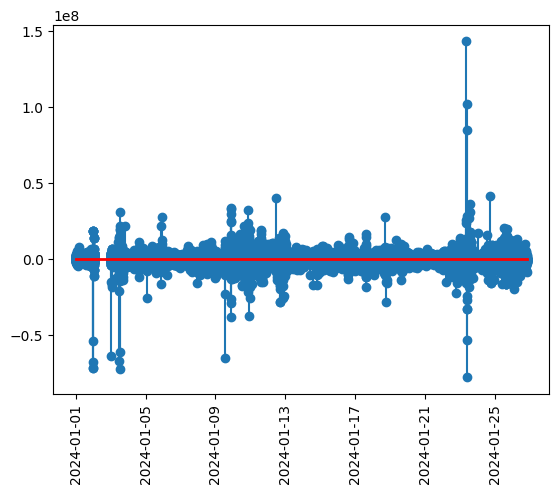

In [8]:

df['diff'] = df['dollar_open_interest_close'].diff()
df_jan2324 = df.loc[(df['time']>'2024-01-24')]
df_jan2324 = df
x = df_jan2324['time']
y = df_jan2324['diff']
plt.xticks(rotation=90)
markerline, stemlines, baseline  = plt.stem(x,y)
plt.setp(baseline, color='r', linewidth=2)

plt.show()


In [13]:
from scipy import stats
import math

df_slice = df_jan2324.loc[df_jan2324['search_resolution']==1]
print(df_slice)

df_slice = df_slice.sort_values(by='time')
df_slice = df_slice.drop_duplicates(subset=['time'])

window_size = 120
step = 60
start = 0
end = start + window_size
max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    if tau.statistic < 0:
        if max_decrease_tau['tau'] > tau.statistic:
            max_decrease_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut.iloc[-1]['dollar_open_interest_close']-df_cut.iloc[1]['dollar_open_interest_close']
        print(f"{oi_increase:,f} USD, {tau.statistic}, 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice.iloc[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice.iloc[max_increase_tau['range_high']]['time']}")
        max_increase_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    # print(f"Range: {start} to {end}: {stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])}")
    start += step
    end += step

print(f"Max increase Tau: {max_increase_tau}, date_start: {df_slice.iloc[max_increase_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_increase_tau['range_high']]['time']}")
print(f"Max decrease Tau: {max_decrease_tau}, date_start: {df_slice.iloc[max_decrease_tau['range_low']]['time']}, date_end: date_start: {df_slice.iloc[max_decrease_tau['range_high']]['time']}")

# spot perp basis, funding


       Unnamed: 0                time  product  high_price  \
0               0 2024-01-01 00:00:00  ETHUSDT     2284.79   
1               1 2024-01-01 00:01:00  ETHUSDT     2285.90   
2               2 2024-01-01 00:02:00  ETHUSDT     2286.37   
3               3 2024-01-01 00:03:00  ETHUSDT     2288.44   
4               4 2024-01-01 00:04:00  ETHUSDT     2289.92   
...           ...                 ...      ...         ...   
51371       51371 2024-01-26 19:40:00  ETHUSDT     2258.46   
51372       51372 2024-01-26 19:41:00  ETHUSDT     2257.82   
51373       51373 2024-01-26 19:42:00  ETHUSDT     2256.53   
51374       51374 2024-01-26 19:43:00  ETHUSDT     2256.53   
51375       51375 2024-01-26 19:44:00  ETHUSDT     2255.46   

       coin_open_interest_close  funding_rate  sell_coin_volume  \
0                    779411.923      0.000279           861.942   
1                    779478.029      0.000279           282.335   
2                    779300.292      0.000278         

In [17]:


max_increase_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
max_decrease_tau = {'tau': 0, 'range_low':0, 'range_high':0, 'oi_difference':0}
df = pd.DataFrame()

# calcuate tau, calculate OI increase for those with positive tau, calculate funding and premium avg for the periods
while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    if tau.statistic < 0:
        if max_decrease_tau['tau'] > tau.statistic:
            max_decrease_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    else:
        # get mean premium for period
        premium = df_cut['premium'].mean()
        # get mean funding for period
        funding = df_cut['funding_rate'].mean()
        # OI increase
        oi_increase = df_cut.iloc[-1]['dollar_open_interest_close']-df_cut.iloc[1]['dollar_open_interest_close']
        print(f"{oi_increase:,f} USD, {tau.statistic}, 'Avg funding:' {funding}, 'Avg premium:' {premium}, 'date_start': {df_slice.iloc[max_increase_tau['range_low']]['time']}, 'date_end': {df_slice.iloc[max_increase_tau['range_high']]['time']}")
        max_increase_tau = {'tau': tau.statistic, 'range_low': start, 'range_high': end}
    # print(f"Range: {start} to {end}: {stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])}")
    start += step
    end += step



Index(['Unnamed: 0', 'time', 'product', 'high_price',
       'coin_open_interest_close', 'funding_rate', 'sell_coin_volume',
       'search_resolution', 'search_end_time', 'liquidations_dollar_volume',
       'dollar_open_interest_high', 'total_trades',
       'dollar_open_interest_close', 'coin_open_interest_low',
       'buy_liquidations', 'liquidations_coin_volume', 'buy_trades',
       'dollar_volume', 'buy_dollar_volume', 'sell_liquidations',
       'sell_dollar_volume', 'low_price', 'buy_coin_volume',
       'coin_open_interest_high', 'premium', 'open_price',
       'dollar_open_interest_low', 'search_start_time', '_id',
       'sell_liquidations_dollar_volume', 'coin_volume', 'close_price',
       'buy_liquidations_coin_volume', 'exchange',
       'sell_liquidations_coin_volume', 'buy_liquidations_dollar_volume',
       'coin', 'sell_trades', 'search_params', 'diff'],
      dtype='object')

In [62]:
from scipy import stats
import math

df_slice = df_jan2324.loc[df_jan2324['search_resolution']==1]
df_slice = df_slice.sort_values(by='time')
df_slice = df_slice.drop_duplicates(subset=['time'])

window_size = 120
step = 60
start = 0
end = start + window_size

df = pd.DataFrame(columns= ['date_start',
                            'date_end',
                            'oi_increase',
                            'tau_stat',
                            'avg_funding',
                            'avg_premium',
                            'oc_price_change',
                            'cc_price_change'])

while end < len(df_slice):
    df_cut = df_slice.iloc[start:end]
    df_cut2 = df_slice.iloc[end:end+step]

    # get tau stat
    tau = stats.kendalltau(df_cut.index, df_cut['dollar_open_interest_close'])
    # get mean premium for period
    premium = df_cut['premium'].mean()
    # get mean funding for period
    funding = df_cut['funding_rate'].mean()
    # OI increase
    oi_increase = df_cut.iloc[-1]['dollar_open_interest_close']-df_cut.iloc[1]['dollar_open_interest_close']
    # OC Price change
    oc_price_change = df_cut.iloc[-1]['close_price']/df_cut.iloc[1]['open_price']-1
    
    # CC Price change
    cc_price_change = df_cut2.iloc[-1]['close_price']/df_cut.iloc[-1]['close_price']-1

    # Create Row
    row = [df_cut.iloc[0].time , df_cut.iloc[-1].time ,oi_increase , tau.statistic , funding , premium , oc_price_change , cc_price_change ]
    #print(row)
    df.loc[len(df)] = row
    
    start += step
    end += step


df['oc_price_change_shift'] = df['oc_price_change'].shift(-1)
df['cc_price_change_shift'] = df['cc_price_change'].shift(-1)

df = df.reset_index(drop=True)
df.head()

,date_start,date_end,oi_increase,tau_stat,avg_funding,avg_premium,oc_price_change,cc_price_change,oc_price_change_shift,cc_price_change_shift
0,2024-01-01 00:00:00,2024-01-01 01:59:00,3.298405e+07,0.810924,0.000290,1.946000,0.009554,-0.004563,-0.000562,-0.008540
1,2024-01-01 01:00:00,2024-01-01 02:59:00,9.506231e+06,0.043137,0.000308,1.985470,-0.000562,-0.008540,-0.012931,0.002575
2,2024-01-01 02:00:00,2024-01-01 03:59:00,-3.414642e+07,-0.782353,0.000322,1.866019,-0.012931,0.002575,-0.005995,-0.001530
3,2024-01-01 03:00:00,2024-01-01 04:59:00,-1.157108e+07,-0.005042,0.000325,1.739656,-0.005995,-0.001530,0.000870,0.002406
4,2024-01-01 04:00:00,2024-01-01 05:59:00,1.449731e+07,0.538375,0.000321,1.701236,0.000870,0.002406,0.000188,0.001323


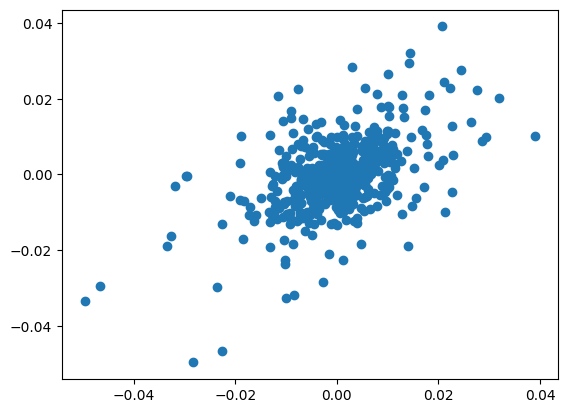

In [79]:
plt.scatter(df['oc_price_change'], df['oc_price_change_shift'])
plt.show() 